## Import packages

In [6]:
import numpy as np
import random
import operator 
import pandas as pd 
import matplotlib.pyplot as plt
import math
import time

## Define fitness function for TSP problem

In [7]:
def routeFitness(route, dm):
    dist = 0
    for i in range(len(route)-1):
        dist += dm[route[i], route[i+1]]
    dist += dm[route[-1], route[0]]
    fitness = 1/dist
    
    return fitness

## Define a function to compute euclidean matrix between points

In [8]:
def dist_matrix(df):
    list_of_distances = [] # just to make it simple, probably there are 1k better ways to do this
    for point in df.itertuples():
        a = point[1]
        b = point[2]
        for point_s in df.itertuples():
            c = point_s[1]
            d = point_s[2]
            dist = math.sqrt(((c-a)**2) + ((d-b)**2))
            list_of_distances.append(dist)
    dist_matrix = np.array(list_of_distances) # convertion to array
    dist_matrix = np.reshape(dist_matrix, (len(df), len(df))) # reshaping
    # dist_matrix.shape # check
    return dist_matrix

## Define a function to initialize our population

In [9]:
def initPopulation(popSize, cities):
    population = []
    [population.append(random.sample(cities, len(cities))) for i in range(0, popSize)]
#     for i in range(0, popSize):
#         population.append(createRoute(cityList))
    return population

## Define a function to compute the error

In [10]:
def errPerc(exactValue, currValue, nRound = 2):
    errp = round((abs(exactValue - currValue) / exactValue)*100, nRound)
    return errp

## Define the main algorithm

In [46]:
def GenA(permutation, dm, popSize, elite_n, mutation_r, n_of_gen, plot = False):
    start = time.time()
    pop = initPopulation(popSize, permutation)
    fitness = {}
    [fitness.update({i:routeFitness(pop[i], dm)}) for i in range(0,len(pop))]
    rankedRoutes = sorted(fitness.items(), key = operator.itemgetter(1), reverse = True)
    
    if plot:
        progress = []
        progress.append(1 / rankedRoutes[0][1])
    
    print("Initial distance: " + str(1 / rankedRoutes[0][1]))
    
    for k in range(0, n_of_gen):
        
        ##################
        # Ranking routes #
        ##################
        
        fitness = {}
        [fitness.update({i:routeFitness(pop[i], dm)}) for i in range(0,len(pop))]
        rankedRoutes = sorted(fitness.items(), key = lambda kv: kv[1], reverse = True)
        
        ########
        # plot #
        ########
        
        if plot:
            progress.append(1 / rankedRoutes[0][1])

        #############
        # selection #
        #############
        
        selectionR = []
        df = pd.DataFrame(np.array(rankedRoutes), columns=["Index","Fitness"])
        df['cum_sum'] = df.Fitness.cumsum()
        df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
        
        [selectionR.append(rankedRoutes[i][0]) for i in range(0, elite_n)]
        
        for i in range(0, len(rankedRoutes) - elite_n):
            pick = 100*random.random()
            for i in range(0, len(rankedRoutes)):
                if pick <= df.iat[i,3]:
                    selectionR.append(rankedRoutes[i][0])
                    break  
        
        ###############
        # mating pool #
        ###############
        
        mp = []
        [mp.append(pop[selectionR[i]]) for i in range(0, len(selectionR))]

        #############
        # Crossover #
        #############
        
        children = []
        length = (len(mp) - elite_n)
        pool = random.sample(mp, len(mp))
        [children.append(mp[i]) for i in range(0, elite_n)]
        
        for i in range(0, length):
            parent1 = pool[i]
            parent2 = pool[len(mp)-i-1]
            child = []
            childP1 = []
            childP2 = []
    
            geneA = int(random.random() * len(parent1))
            geneB = int(random.random() * len(parent1))
            
            startGene = min(geneA, geneB)
            endGene = max(geneA, geneB)
            [childP1.append(parent1[i]) for i in range(startGene, endGene)]
            childP2 = [item for item in parent2 if item not in childP1]
            
            child = childP1 + childP2
            children.append(child)
        
        ############
        # mutation #
        ############
        
        mutatedPop = []
    
        for ind in range(0, len(children)):
            individual = children[ind]
            for swapped in range(len(individual)):
                if(random.random() < mutation_r):
                    swapWith = int(random.random() * len(individual))
            
                    city1 = individual[swapped]
                    city2 = individual[swapWith]
            
                    individual[swapped] = city2
                    individual[swapWith] = city1
            mutatedPop.append(individual)
        
        ##############
        # update pop #
        ##############
        
        pop = mutatedPop
        
    
    
    ###########
    # results #
    ###########
    
    fitness = {}
    [fitness.update({i:routeFitness(pop[i], dm)}) for i in range(0,len(pop))]
    rankedRoutes = sorted(fitness.items(), key = lambda kv: kv[1], reverse = True)
    bestDistance = 1 / rankedRoutes[0][1]
    print("Final distance: {}".format(bestDistance))
    bestRouteIndex = rankedRoutes[0][0]
    bestRoute = pop[bestRouteIndex]
    time_executed = (time.time() - start)
    print("Algorithm completed in {} s".format(time_executed))
    
    if plot:
        plt.plot(progress)
        plt.ylabel('Distance')
        plt.xlabel('Generation')
        plt.show()
    
    return bestRoute, bestDistance, time_executed

## Running the algorithm

Import our data

In [32]:
df_berlin52 = pd.read_csv("berlin52.tsp", header=None, sep = " ", names = ['x', 'y'], index_col = 0)
df_pr76 = pd.read_csv("pr76.tsp", header=None, sep = " ", names = ['x', 'y'], index_col = 0)
df_ch150 = pd.read_csv("ch150.tsp", header=None, sep = " ", names = ['x', 'y'], index_col = 0)
df_a280 = pd.read_csv("a280.tsp", header=None, sep = ",", names = ['x', 'y'], index_col = 0)
bestKnown_tsp = {
    'berlin52':7542,
    'pr76':108159,
    'ch150':6528,
    'a280':2579}
list_dist = []
list_time = []
list_route = []

### berlin52

In [33]:
cities = []
cities = list(range(len(df_berlin52)))
d_matrix = dist_matrix(df_berlin52)

Initial distance: 31624.74029818603
Final distance: 28063.97486722315
Algorithm completed in 7.436146974563599 s


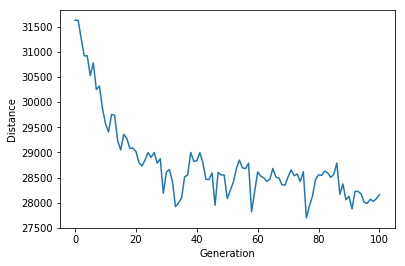

With an error to minimal value of: 272.1%


In [47]:
route, dist, time_ex = GenA(permutation = cities, dm = d_matrix,
                         popSize = 100,
                         elite_n = 25,
                         mutation_r = 0.01,
                         n_of_gen = 100,
                           plot = True)

print('With an error to minimal value of: {}%'.format(errPerc(bestKnown_tsp['berlin52'], dist, 2)))
list_dist.append(dist)
list_time.append(time_ex)
list_route.append(route)

### pr76

In [48]:
cities = []
cities = list(range(len(df_pr76)))
d_matrix = dist_matrix(df_pr76)

Initial distance: 513968.18854919274
Final distance: 354752.36754738254
Algorithm completed in 36.741140604019165 s


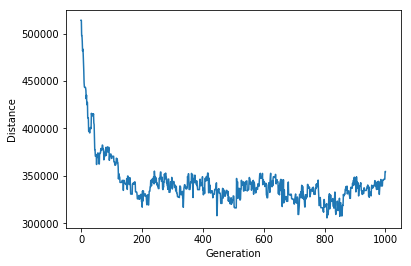

With an error to minimal value of: 227.99%


In [49]:
route, dist, time_ex = GenA(permutation = cities, dm = d_matrix,
                         popSize = 100,
                         elite_n = 25,
                         mutation_r = 0.01,
                         n_of_gen = 1000,
                           plot = True)
print('With an error to minimal value of: {}%'.format(errPerc(bestKnown_tsp['pr76'], dist, 2)))
list_dist.append(dist)
list_time.append(time_ex)
list_route.append(route)

### ch150

In [50]:
cities = []
cities = list(range(len(df_ch150)))
d_matrix = dist_matrix(df_ch150)

Initial distance: 49259.59241705724
Final distance: 38821.375821474176
Algorithm completed in 48.10326170921326 s


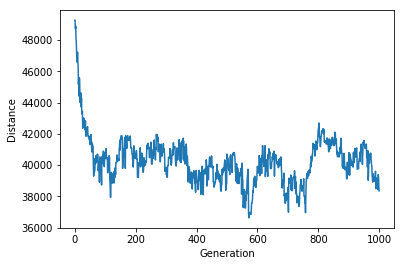

With an error to minimal value of: 494.69%


In [51]:
route, dist, time_ex = GenA(permutation = cities, dm = d_matrix,
                         popSize = 100,
                         elite_n = 25,
                         mutation_r = 0.01,
                         n_of_gen = 1000,
                           plot = True)
print('With an error to minimal value of: {}%'.format(errPerc(bestKnown_tsp['ch150'], dist, 2)))
list_dist.append(dist)
list_time.append(time_ex)
list_route.append(route)

### a280

In [52]:
cities = []
cities = list(range(len(df_a280)))
d_matrix = dist_matrix(df_a280)

Initial distance: 31841.41745538738
Final distance: 27128.043406339828
Algorithm completed in 75.79109978675842 s


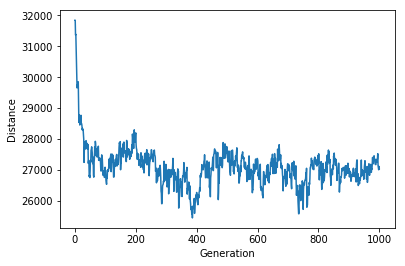

With an error to minimal value of: 951.88%


In [53]:
route, dist, time_ex = GenA(permutation = cities, dm = d_matrix,
                         popSize = 100,
                         elite_n = 25,
                         mutation_r = 0.01,
                         n_of_gen = 1000,
                           plot = True)
print('With an error to minimal value of: {}%'.format(errPerc(bestKnown_tsp['a280'], dist, 2)))
list_dist.append(dist)
list_time.append(time_ex)
list_route.append(route)

## Results

In [41]:
ndx = list(bestKnown_tsp.keys())

In [42]:
list_tuples = list(zip(list_dist, list_time))
results = pd.DataFrame(list_tuples, columns = ['distance', 'time'], index = ndx)
results

,distance,time
berlin52,17096.532866,3.476370
pr76,350259.816928,37.161580
ch150,39643.056827,47.177792
a280,27613.211269,78.719627
